### The goal of this notebook is to identify which Bedmap1 points are covered by other datasets

In [1]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

import importlib
import numpy as np
import os
import pathlib
import shapefile as shp  # Requires the pyshp package; I ran `pip install pyshp`


In [2]:
import detangle_bedmap_utils
importlib.reload(detangle_bedmap_utils)
from detangle_bedmap_utils import (expand_range, find_closest_bedmap,
                                   load_bedmap_ll, load_bedmap_xy, 
                                   subsample_tracks_uniform, 
                                  )

In [3]:
gl_filepath = "/Users/lindzey/Data/Quantarctica3/Glaciology/ASAID/ASAID_GroundingLine_Simplified.shp"

# If I do it this way, I can plot as points (but not lines!). This is easier than having to iterate through each segment.
sf = shp.Reader(gl_filepath)
gl_xx = []
gl_yy = []
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    gl_xx.extend(x)
    gl_yy.extend(y)

In [4]:
bm1_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP1/BEDMAP1_1966-2000_AIR_BM1.csv"
bm1_lon, bm1_lat = load_bedmap_ll(bm1_path)
bm1_xx, bm1_yy = load_bedmap_xy(bm1_path)

## BAS

Two surveys in both BM1 and BM2:
* 1994_Evans
* 1998_Dufek

In [5]:
duplicate_bas_surveys = ["BAS_1994_Evans_AIR_BM2", "BAS_1998_Dufek_AIR_BM2"]

In [6]:
bas_xx = {}
bas_yy = {}
bas_bm1_idxs = {}

for idx, survey in enumerate(duplicate_bas_surveys):
    bas_path = "/Users/lindzey/RadarData/ANTARCTIC/BEDMAP/BEDMAP2/{}.csv".format(survey)
    bas_xx[survey], bas_yy[survey] = load_bedmap_xy(bas_path)
    bas_bm1_idxs[survey] = find_closest_bedmap(bas_xx[survey], bas_yy[survey], bm1_xx, bm1_yy, decimation=50)    

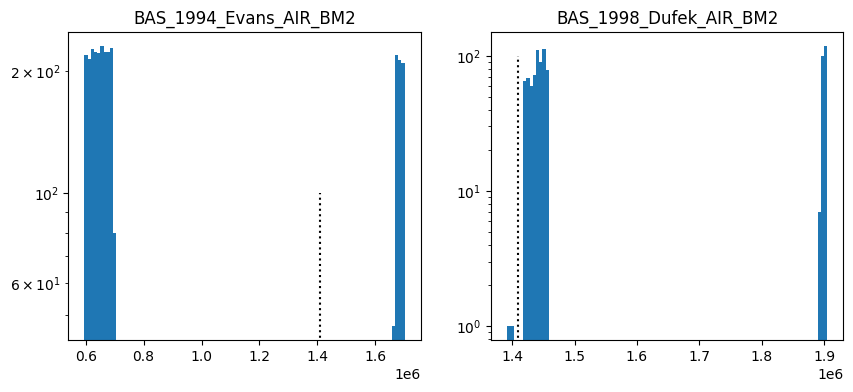

In [7]:
fig = plt.figure(figsize=(10,4))
axs = fig.subplots(1,2)

for idx, survey in enumerate(duplicate_bas_surveys):
    ax = axs[idx]
    ax.hist(bas_bm1_idxs[survey], bins=100);
    ax.set_title(survey)
    ax.set_yscale('log')
    
    ax.vlines([1.41e6], 0, 100, linestyle='dotted', colors='black')
    

In [8]:
bas_survey_bounds = {}
bas_survey_bounds["BAS_1994_Evans_AIR_BM2"] = (5e5, 8e5, 1.6e6, 1.8e6)
bas_survey_bounds["BAS_1998_Dufek_AIR_BM2"] = (1.41e6, 1.5e6, 1.85e6, 1.95e6)


In [9]:
bas_survey_ranges = {}
for idx, survey in enumerate(duplicate_bas_surveys):
    min1, max1, min2, max2 = bas_survey_bounds[survey]
    
    i1, = np.where(min1 < bas_bm1_idxs[survey])
    i2, = np.where(bas_bm1_idxs[survey] < max1)
    group1_idxs = np.intersect1d(i1, i2)
    group1_idxs = np.array(bas_bm1_idxs[survey])[group1_idxs]

    i1, = np.where(min2 < bas_bm1_idxs[survey])
    i2, = np.where(bas_bm1_idxs[survey] < max2)
    group2_idxs = np.intersect1d(i1, i2)
    group2_idxs = np.array(bas_bm1_idxs[survey])[group2_idxs]

    # See about extending the bedmap range a bit, in case we missed any
    radius = 10000
    group1_start, group1_end = expand_range(group1_idxs, bas_xx[survey], bas_yy[survey], bm1_xx, bm1_yy, radius)
    group2_start, group2_end = expand_range(group2_idxs, bas_xx[survey], bas_yy[survey], bm1_xx, bm1_yy, radius)
    
    group1_range = np.arange(group1_start, group1_end+1)  # group1_end is inclusive
    group2_range = np.arange(group2_start, group2_end+1) 
    bas_survey_ranges[survey] = (group1_range, group2_range)
    
    print("For {}, {} orig points, {} + {} = {} BM1 points"
          .format(survey, len(bas_xx[survey]), len(group1_range), len(group2_range), 
                  len(group1_range) + len(group2_range)))

For BM1 idx 595687, min_dist = 1279.30 km
For BM1 idx 699240, min_dist = 3375.41 km
For BM1 idx 1665966, min_dist = 1290.20 km
For BM1 idx 1701480, min_dist = 3373.43 km
For BAS_1994_Evans_AIR_BM2, 139174 orig points, 103552 + 35513 = 139065 BM1 points
For BM1 idx 1418778, min_dist = 2278.20 km
For BM1 idx 1458534, min_dist = 1719.78 km
For BM1 idx 1894447, min_dist = 2280.39 km
For BM1 idx 1905050, min_dist = 0.00 km
For BAS_1998_Dufek_AIR_BM2, 44088 orig points, 39755 + 10602 = 50357 BM1 points


The BAS_1994_Evans_AIR_BM2 survey includes 595688-699239 and 1665967-1701479
The BAS_1998_Dufek_AIR_BM2 survey includes 1418779-1458533 and 1894448-1905049


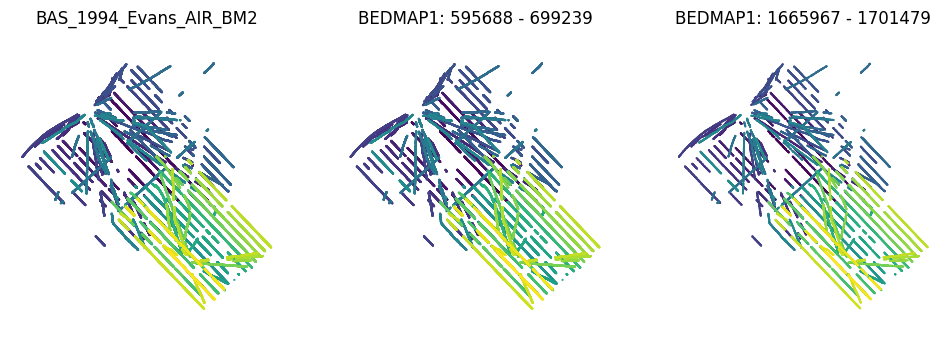

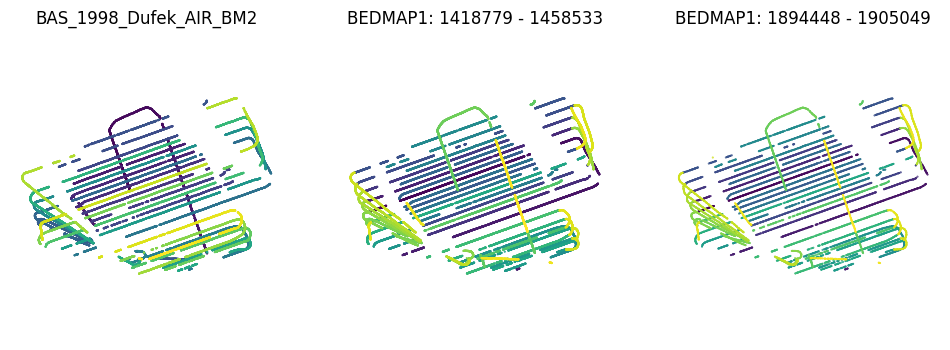

In [10]:
for survey in duplicate_bas_surveys:
    group1_range, group2_range = bas_survey_ranges[survey]
    print("The {} survey includes {}-{} and {}-{}".format(survey, np.min(group1_range), np.max(group1_range), 
                                                          np.min(group2_range), np.max(group2_range)))
    
    fig = plt.figure(figsize=(12,4))
    ax1, ax2, ax3, = fig.subplots(1,3)
    for ax in [ax1, ax2, ax3]:
        ax.axis('equal') 
        ax.axis('off')
    ax1.scatter(bas_xx[survey], bas_yy[survey], c=np.arange(0,len(bas_xx[survey])), edgecolors=None, s=0.3)
    ax1.set_title(survey)
    
    ax2.scatter(bm1_xx[group1_range], bm1_yy[group1_range], c=np.arange(0, len(group1_range)), edgecolors=None, s=0.3)
    #ax2.scatter(bm1_xx[group1_idxs], bm1_yy[group1_idxs], c=group1_idxs, edgecolors=None, s=0.3)
    ax2.set_title("BEDMAP1: {} - {}".format(group1_range[0], group1_range[-1]))
     
    ax3.scatter(bm1_xx[group2_range], bm1_yy[group2_range], c=np.arange(0, len(group2_range)), edgecolors=None, s=0.2)
    #ax3.scatter(bm1_xx[group2_idxs], bm1_yy[group2_idxs], c=group2_idxs, edgecolors=None, s=0.2)
    ax3.set_title("BEDMAP1: {} - {}".format(group2_range[0], group2_range[-1]))

Final bounds: 
```
The BAS_1994_Evans_AIR_BM2 survey includes 595688-699239 and 1665967-1701479
The BAS_1998_Dufek_AIR_BM2 survey includes 1418779-1458533 and 1894448-1905049
```
